In [1]:
import os
print os.environ['PYSPARK_PYTHON']
os.environ['PYSPARK_PYTHON']=os.environ['LCG_VIEW'] + '/bin/python'
print os.environ['PYSPARK_PYTHON']

/etc/spark/python
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/bin/python


In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

## read traces from hadoop

In [3]:
df = spark.read.json("/user/rucio01/traces/traces.2018-04*")
df.createOrReplaceTempView("traces")

## select all official (according to split schema) download events

In [4]:
df_ps = spark.sql("SELECT *\
                    FROM traces \
                    WHERE eventType=='download' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')")\


## split dataset column according to schema

In [5]:
split_col = split(df['dataset'], "\.")
df_ps = df_ps.withColumn('project', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(0)).otherwise(None))
df_ps = df_ps.withColumn('run_number', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(1)).otherwise(None))
df_ps = df_ps.withColumn('stream_name', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(2)).otherwise(None))
df_ps = df_ps.withColumn('prod_step', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(3)).otherwise(None))
df_ps = df_ps.withColumn('datatype', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(4)).otherwise(None))
df_ps = df_ps.withColumn('dataset_version', when(df_ps['dataset'].like('mc%') | df_ps['dataset'].like('data%'), split_col.getItem(5)).otherwise(None))

df_ps.createOrReplaceTempView("cols")

## create new table that counts all downloads per dataset

In [6]:
df_ps_counts = spark.sql("SELECT dataset AS dataset_counts, count(*) as hits \
                               FROM traces \
                               WHERE eventType=='download' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')\
                               GROUP BY  dataset \
                               ORDER BY 2 DESC")
df_ps_counts.createOrReplaceTempView("counts")

## join both tables

In [7]:
df_ps_merged = spark.sql("SELECT * \
                               FROM cols \
                               INNER JOIN counts ON cols.dataset = counts.dataset_counts")
df_ps_merged.limit(10).toPandas()

account appid catStart clientState  \
0  ichiu   None  None     DONE         
1  ichiu   None  None     DONE         
2  ichiu   None  None     DONE         
3  ichiu   None  None     DONE         
4  ichiu   None  None     DONE         
5  ichiu   None  None     DONE         
6  ichiu   None  None     DONE         
7  ichiu   None  None     DONE         
8  ichiu   None  None     DONE         
9  ichiu   None  None     DONE         

                                                                   dataset  \
0  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
1  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
2  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
3  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
4  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
5  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
6  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
7  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
8  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
9  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   

  datasetName  datasetScope dataset_scope  duid eventType ...  validateStart  \
0  None        data15_13TeV  None          None  download ...   None           
1  None        data15_13TeV  None          None  download ...   None           
2  None        data15_13TeV  None          None  download ...   None           
3  None        data15_13TeV  None          None  download ...   None           
4  None        data15_13TeV  None          None  download ...   None           
5  None        data15_13TeV  None          None  download ...   None           
6  None        data15_13TeV  None          None  download ...   None           
7  None        data15_13TeV  None          None  download ...   None           
8  None        data15_13TeV  None          None  download ...   None           
9  None        data15_13TeV  None          None  download ...   None           

  version       project run_number   stream_name prod_step      datatype  \
0  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
1  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
2  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
3  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
4  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
5  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
6  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
7  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
8  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
9  None    data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   

     dataset_version  \
0  r9264_p3083_p3372   
1  r9264_p3083_p3372   
2  r9264_p3083_p3372   
3  r9264_p3083_p3372   
4  r9264_p3083_p3372   
5  r9264_p3083_p3372   
6  r9264_p3083_p3372   
7  r9264_p3083_p3372   
8  r9264_p3083_p3372   
9  r9264_p3083_p3372   

                                                            dataset_counts  \
0  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
1  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
2  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
3  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
4  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
5  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
6  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
7  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
8  data15_13TeV.0

## fill missing values in numerical columns with zero

In [8]:
from pyspark.sql.types import DoubleType

df_ps_merged = df_ps_merged.withColumn("filesize_double", df_ps_merged["filesize"].cast(DoubleType()))
#df_cleaned.printSchema()

In [9]:
df_cleaned = df_ps_merged.fillna(0.0, subset=["catStart", "relativeStart", "timeEnd", "timeStart", "traceTimeentryUnix", "transferEnd", "transferStart", "validateStart", "filesize_double", "hits"])

## create feature vector column from numerical values for correlation

In [10]:
assembler = VectorAssembler(inputCols=["catStart", "relativeStart", "timeEnd", "timeStart", "traceTimeentryUnix", "transferEnd", "transferStart", "validateStart", "filesize_double", "hits"], outputCol="features")
output = assembler.transform(df_cleaned)
output.limit(10).toPandas()

account appid  catStart clientState  \
0  ichiu   None  0.0       DONE         
1  ichiu   None  0.0       DONE         
2  ichiu   None  0.0       DONE         
3  ichiu   None  0.0       DONE         
4  ichiu   None  0.0       DONE         
5  ichiu   None  0.0       DONE         
6  ichiu   None  0.0       DONE         
7  ichiu   None  0.0       DONE         
8  ichiu   None  0.0       DONE         
9  ichiu   None  0.0       DONE         

                                                                   dataset  \
0  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
1  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
2  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
3  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
4  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
5  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
6  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
7  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
8  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   
9  data15_13TeV.00280862.physics_Main.deriv.DAOD_HIGG4D4.r9264_p3083_p3372   

  datasetName  datasetScope dataset_scope  duid eventType  \
0  None        data15_13TeV  None          None  download   
1  None        data15_13TeV  None          None  download   
2  None        data15_13TeV  None          None  download   
3  None        data15_13TeV  None          None  download   
4  None        data15_13TeV  None          None  download   
5  None        data15_13TeV  None          None  download   
6  None        data15_13TeV  None          None  download   
7  None        data15_13TeV  None          None  download   
8  None        data15_13TeV  None          None  download   
9  None        data15_13TeV  None          None  download   

                                              ...                                              \
0                                             ...                                               
1                                             ...                                               
2                                             ...                                               
3                                             ...                                               
4                                             ...                                               
5                                             ...                                               
6                                             ...                                               
7                                             ...                                               
8                                             ...                                               
9                                             ...                                               

        project run_number   stream_name prod_step      datatype  \
0  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
1  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
2  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
3  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
4  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
5  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
6  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
7  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
8  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   
9  data15_13TeV  00280862   physics_Main  deriv     DAOD_HIGG4D4   

     dataset_version  \
0  r9264_p3083_p3372   
1  r9264_p3083_p3372   
2  r9264_p3083_p3372   
3  r9264_p3083_p3372   
4  r9264_p3083_p3372   
5  r9264_p3083_p3372   
6  r9264_p3083_p3372   
7  r9264_p

## compute correlation matrix

In [11]:
from pyspark.ml.stat import Correlation

r1 = Correlation.corr(output, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan,         nan,         nan],
             [        nan,  1.        ,         nan,         nan,         nan,
                      nan,         nan,         nan,         nan,         nan],
             [        nan,         nan,  1.        ,         nan,         nan,
                      nan,         nan,         nan,         nan,         nan],
             [        nan,         nan,         nan,  1.        ,         nan,
                      nan,         nan,         nan,         nan,         nan],
             [        nan,         nan,         nan,         nan,  1.        ,
              -0.10919774,  0.35216917,         nan,  0.19036901,  0.09683604],
             [        nan,         nan,         nan,         nan, -0.10919774,
               1.        , -0.03569891,         nan, -0.41305099, -0.03369534],
             [    

In [12]:
array = r1[0].toArray()
corr_map = pd.DataFrame.from_records(data=array, columns=["catStart", "relativeStart", "timeEnd", "timeStart", "traceTimeentryUnix", "transferEnd", "transferStart", "validateStart", "filesize_double", "hits"])
corr_map

#there's no variance/ standard deviation in the second column and thus in the correlation coefficient calculation when you divide by std or var (however it's implemented) you're in turn dividing zero by zero which yield nan.

catStart  relativeStart  timeEnd  timeStart  traceTimeentryUnix  \
0  1.0      NaN            NaN      NaN        NaN                   
1 NaN        1.0           NaN      NaN        NaN                   
2 NaN       NaN             1.0     NaN        NaN                   
3 NaN       NaN            NaN       1.0       NaN                   
4 NaN       NaN            NaN      NaN         1.000000             
5 NaN       NaN            NaN      NaN        -0.109198             
6 NaN       NaN            NaN      NaN         0.352169             
7 NaN       NaN            NaN      NaN        NaN                   
8 NaN       NaN            NaN      NaN         0.190369             
9 NaN       NaN            NaN      NaN         0.096836             

   transferEnd  transferStart  validateStart  filesize_double      hits  
0 NaN          NaN            NaN            NaN              NaN        
1 NaN          NaN            NaN            NaN              NaN        
2 NaN          NaN            NaN            NaN              NaN        
3 NaN          NaN            NaN            NaN              NaN        
4 -0.109198     0.352169      NaN             0.190369         0.096836  
5  1.000000    -0.035699      NaN            -0.413051        -0.033695  
6 -0.035699     1.000000      NaN             0.055282         0.034872  
7 NaN          NaN             1.0           NaN              NaN        
8 -0.413051     0.055282      NaN             1.000000        -0.013266  
9 -0.033695     0.034872      NaN            -0.013266         1.000000

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


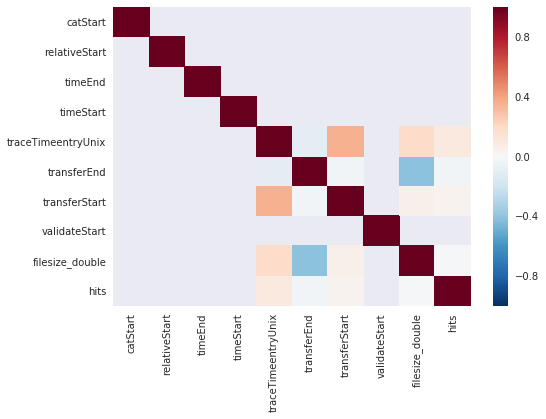

In [13]:
sns.heatmap(corr_map, yticklabels=["catStart", "relativeStart", "timeEnd", "timeStart", "traceTimeentryUnix", "transferEnd", "transferStart", "validateStart", "filesize_double", "hits"])

In [14]:
from pyspark.sql.functions import *

# Implementation of ANOVA function: calculates the degrees of freedom, F-value, eta squared and omega squared values.
# Expects that 'categoryData' with two columns, the first being the categorical independent variable and the second being the scale dependent variable
# Berechnung: http://www.methodenberatung.uzh.ch/de/datenanalyse/unterschiede/zentral/evarianz.html
# https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php

def getAnovaStats(categoryData) : 
    #try:
        print(str(categoryData.columns))
        cat_val = categoryData.toDF("cat","value")
        cat_val.createOrReplaceTempView("df")
        newdf = spark.sql("select A.cat, A.value, cast((A.value * A.value) as double) as valueSq, ((A.value - B.avg) * (A.value - B.avg)) as diffSq from df A join (select cat, avg(value) as avg from df group by cat) B where A.cat = B.cat")
        grouped = newdf.groupBy("cat")
        sums = grouped.sum("value")
        counts = grouped.count()
        numCats = counts.count() 
        sumsq = grouped.sum("valueSq") 
        avgs = grouped.avg("value")
    
        totN = counts.selectExpr("sum(count) as total").rdd.map(lambda x: x.total).collect()[0]
        totSum = sums.selectExpr("sum(`sum(value)`) as totSum").rdd.map(lambda x: x.totSum).collect()[0]
        totSumSq = sumsq.selectExpr("sum(`sum(valueSq)`) as totSumSq").rdd.map(lambda x: x.totSumSq).collect()[0]

        print("totN:" + str(totN) + " totSum: " + str(totSum) + " totSumSq: " + str(totSumSq) + " sums: " + str(sums) + " counts: " + str(counts) + " numCats: " + str(numCats) + " sumsq: " + str(sumsq) + " avgs: " + str(avgs))
       
        totMean = totSum / totN

        #dft = totN - 1
        # degrees of freedom between groups
        dfb = numCats - 1
        # degrees of freedom within groups
        dfw = totN - numCats
    
        joined = counts.selectExpr("cat as category", "count").join(sums, col("category") == sums.cat, 'inner')\
            .drop(sums.cat)\
            .join(sumsq, col("category") == sumsq.cat, 'inner')\
            .drop(sumsq.cat)\
            .join(avgs, col("category") == avgs.cat, 'inner')\
            .drop(avgs.cat)
        finaldf = joined.withColumn("totMean", lit(totMean))

        # sum of squares between groups
        ssb_tmp = finaldf.rdd.map(lambda x: (x[0], ((x[4] - x[5])*(x[4] - x[5]))*x[1]))
        ssb = ssb_tmp.toDF().selectExpr("sum(_2) as total").rdd.map(lambda x: x.total).collect()[0]

        # sum of squares within groups
        ssw_tmp = grouped.sum("diffSq")
        ssw = ssw_tmp.selectExpr("sum(`sum(diffSq)`) as total").rdd.map(lambda x: x.total).collect()[0]
    
        # sum of squares total
        sst = ssb + ssw

        # mean squares between groups
        print("dfb: " + str(dfb))
        msb = ssb / dfb
        # mean squares within groups
        print("dfw: " + str(dfw))
        msw = ssw / dfw
        # statistic F
        print("msw: " + str(msw))
        F = msb / msw

        # partial eta square => percent of variance of the dependent variable that is predicted by the independent variable
        # when you only have one independent variable, partial eta2 is the same as eta2
        # http://www.statisticshowto.com/eta-squared/
        etaSq = ssb / sst
    
        # Omega squared is widely viewed as a lesser biased alternative to eta-squared, especially when sample sizes are small.
        # ω2 can have values between ± 1.
        # Zero indicates no effect.
        # If the observed F is less than one, ω2 will be negative.
        # http://www.statisticshowto.com/omega-squared/
        omegaSq = (ssb - ((numCats - 1) * msw))/(sst + msw)
        return (dfb, dfw, F, etaSq, omegaSq)
    #except Exception as ex:
        #template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        #message = template.format(type(ex).__name__, ex.args)
        #print message
        #return ('error', message, 0, 0, 0)

In [15]:
#df_cleaned.select('account','hits').limit(10).toPandas()

In [16]:
getAnovaStats(df_cleaned.select('account','hits'))

['account', 'hits']
totN:1645429 totSum: 11579379499 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 545 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 544
dfw: 1644884
msw: 23638949.6398


(544, 1644884, 10218.180749195853, 0.7716572460831989, 0.7715816209064673)

In [17]:
#df_cleaned.printSchema()

In [18]:
#categorical = ['account','appid','clientState','dataset','datasetName','datasetScope','dataset_scope','duid','eventType','eventVersion','filename','guid','hostname','ip','localSite','name','pq','protocol','remoteSite','scope','stateReason','suspicious','taskid','traceId','traceIp','url','usr','usrdn','uuid','version','project','run_number','stream_name','prod_step','datatype','dataset_version']
#result_list = []
#for elem in categorical:
#    stats = getAnovaStats(df_cleaned.select(elem, 'hits'))
#    result_list.append({'column': elem, 'dfb': stats[0], 'dfw': stats[1], 'F': stats[2], 'etaSq': stats[3], 'omegaSq': stats[4]})
#    
#df_anova = pd.DataFrame(result_list)

In [19]:
getAnovaStats(df_cleaned.select('appid','hits'))

['appid', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [20]:
getAnovaStats(df_cleaned.select('clientState','hits'))

['clientState', 'hits']
totN:1645429 totSum: 11579379499 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 12 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 11
dfw: 1645417
msw: 102683806.236


(11, 1645417, 1175.055027795639, 0.007794291278772825, 0.007787653453984247)

In [21]:
getAnovaStats(df_cleaned.select('dataset','hits'))

['dataset', 'hits']
totN:1645429 totSum: 11579379499 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 10885 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 10884
dfw: 1634544
msw: 0.0


ZeroDivisionError: float division by zero

In [22]:
getAnovaStats(df_cleaned.select('datasetName','hits'))

['datasetName', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [23]:
getAnovaStats(df_cleaned.select('datasetScope','hits'))

['datasetScope', 'hits']
totN:1645429 totSum: 11579379499 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 24 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 23
dfw: 1645405
msw: 62136435.5361


(23, 1645405, 47612.84649721446, 0.39959689175361907, 0.39958835331744136)

In [24]:
getAnovaStats(df_cleaned.select('dataset_scope','hits'))

['dataset_scope', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [25]:
getAnovaStats(df_cleaned.select('duid','hits'))

['duid', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [26]:
getAnovaStats(df_cleaned.select('eventType','hits'))

['eventType', 'hits']
totN:1645429 totSum: 11579379499 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 1 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 0


ZeroDivisionError: float division by zero

In [27]:
getAnovaStats(df_cleaned.select('eventVersion','hits'))

['eventVersion', 'hits']
totN:1645429 totSum: 11579379499 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 6 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 5
dfw: 1645423
msw: 101167938.986


(5, 1645423, 7553.533506258753, 0.02243813981376628, 0.022435155936031678)

In [28]:
getAnovaStats(df_cleaned.select('filename','hits'))

['filename', 'hits']
totN:1636613 totSum: 11569490698 totSumSq: 2.51752270146e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 549930 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 549929
dfw: 1086683
msw: 2119.60644155


(549929, 1086683, 145812.01543171392, 0.9999864481978591, 0.9999795901329488)

In [29]:
getAnovaStats(df_cleaned.select('guid','hits'))

['guid', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [30]:
getAnovaStats(df_cleaned.select('hostname','hits'))

['hostname', 'hits']
totN:1645427 totSum: 11579379495 totSumSq: 2.5177251201e+14 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 373 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 372
dfw: 1645054
msw: 29939533.6529


(372, 1645054, 10867.12559714202, 0.7107660789226692, 0.7107005488079452)

In [31]:
getAnovaStats(df_cleaned.select('ip','hits'))

['ip', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [32]:
getAnovaStats(df_cleaned.select('localSite','hits'))

['localSite', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [33]:
getAnovaStats(df_cleaned.select('name','hits'))

['name', 'hits']
totN:8816 totSum: 9888801 totSumSq: 20241864069.0 sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 4473 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]
dfb: 4472
dfw: 4343
msw: 0.0


ZeroDivisionError: float division by zero

In [34]:
getAnovaStats(df_cleaned.select('pq','hits'))

['pq', 'hits']
totN:None totSum: None totSumSq: None sums: DataFrame[cat: string, sum(value): bigint] counts: DataFrame[cat: string, count: bigint] numCats: 0 sumsq: DataFrame[cat: string, sum(valueSq): double] avgs: DataFrame[cat: string, avg(value): double]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [ ]:
getAnovaStats(df_cleaned.select('protocol','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('remoteSite','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('scope','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('stateReason','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('suspicious','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('taskid','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('traceId','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('traceIp','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('url','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('usr','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('usrdn','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('uuid','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('version','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('project','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('run_number','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('stream_name','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('prod_step','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('datatype','hits'))

In [ ]:
getAnovaStats(df_cleaned.select('dataset_version','hits'))